In [1]:
import numpy as np
import pandas as pd
import vip_hci
from os import mkdir
from os.path import join, sep,exists
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from scipy.ndimage.filters import median_filter
from scipy.ndimage.interpolation import shift
from photutils import DAOStarFinder
from astropy.stats import mad_std

Perform H Band reduction

In [2]:
# Set up paths 
frameSize = 351
band = 'H'
tg_name= '2M1207'
useRefFrames = False
path_input = '/home/ubuntu/Downloads/2M1207_bands/Hband/'
path_output = path_input + 'out/'
sep='/'
print(path_input)

path_flats = path_input+'flats'+sep
path_flats_darks = path_input+'flats/darks'+sep
path_sci = path_input+'sci'+sep
path_darks = path_input+'darks'+sep

/home/ubuntu/Downloads/2M1207_bands/Hband/


In [3]:
# File list
filelist_flats = glob.glob(path_flats+'*.fits')
filelist_flats_darks = glob.glob(path_flats_darks+'*.fits')
filelist_sci = sorted(glob.glob(path_sci+'*.fits'))
filelist_darks = glob.glob(path_darks+'*.fits')

print((filelist_sci))

['/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_54_41.920.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_56_08.901.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_57_35.981.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T03_59_03.178.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_00_51.350.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_02_18.216.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_03_44.710.fits', '/home/ubuntu/Downloads/2M1207_bands/Hband/sci/NACO.2004-04-27T04_05_11.355.fits']


# H BAND RAW IMAGE

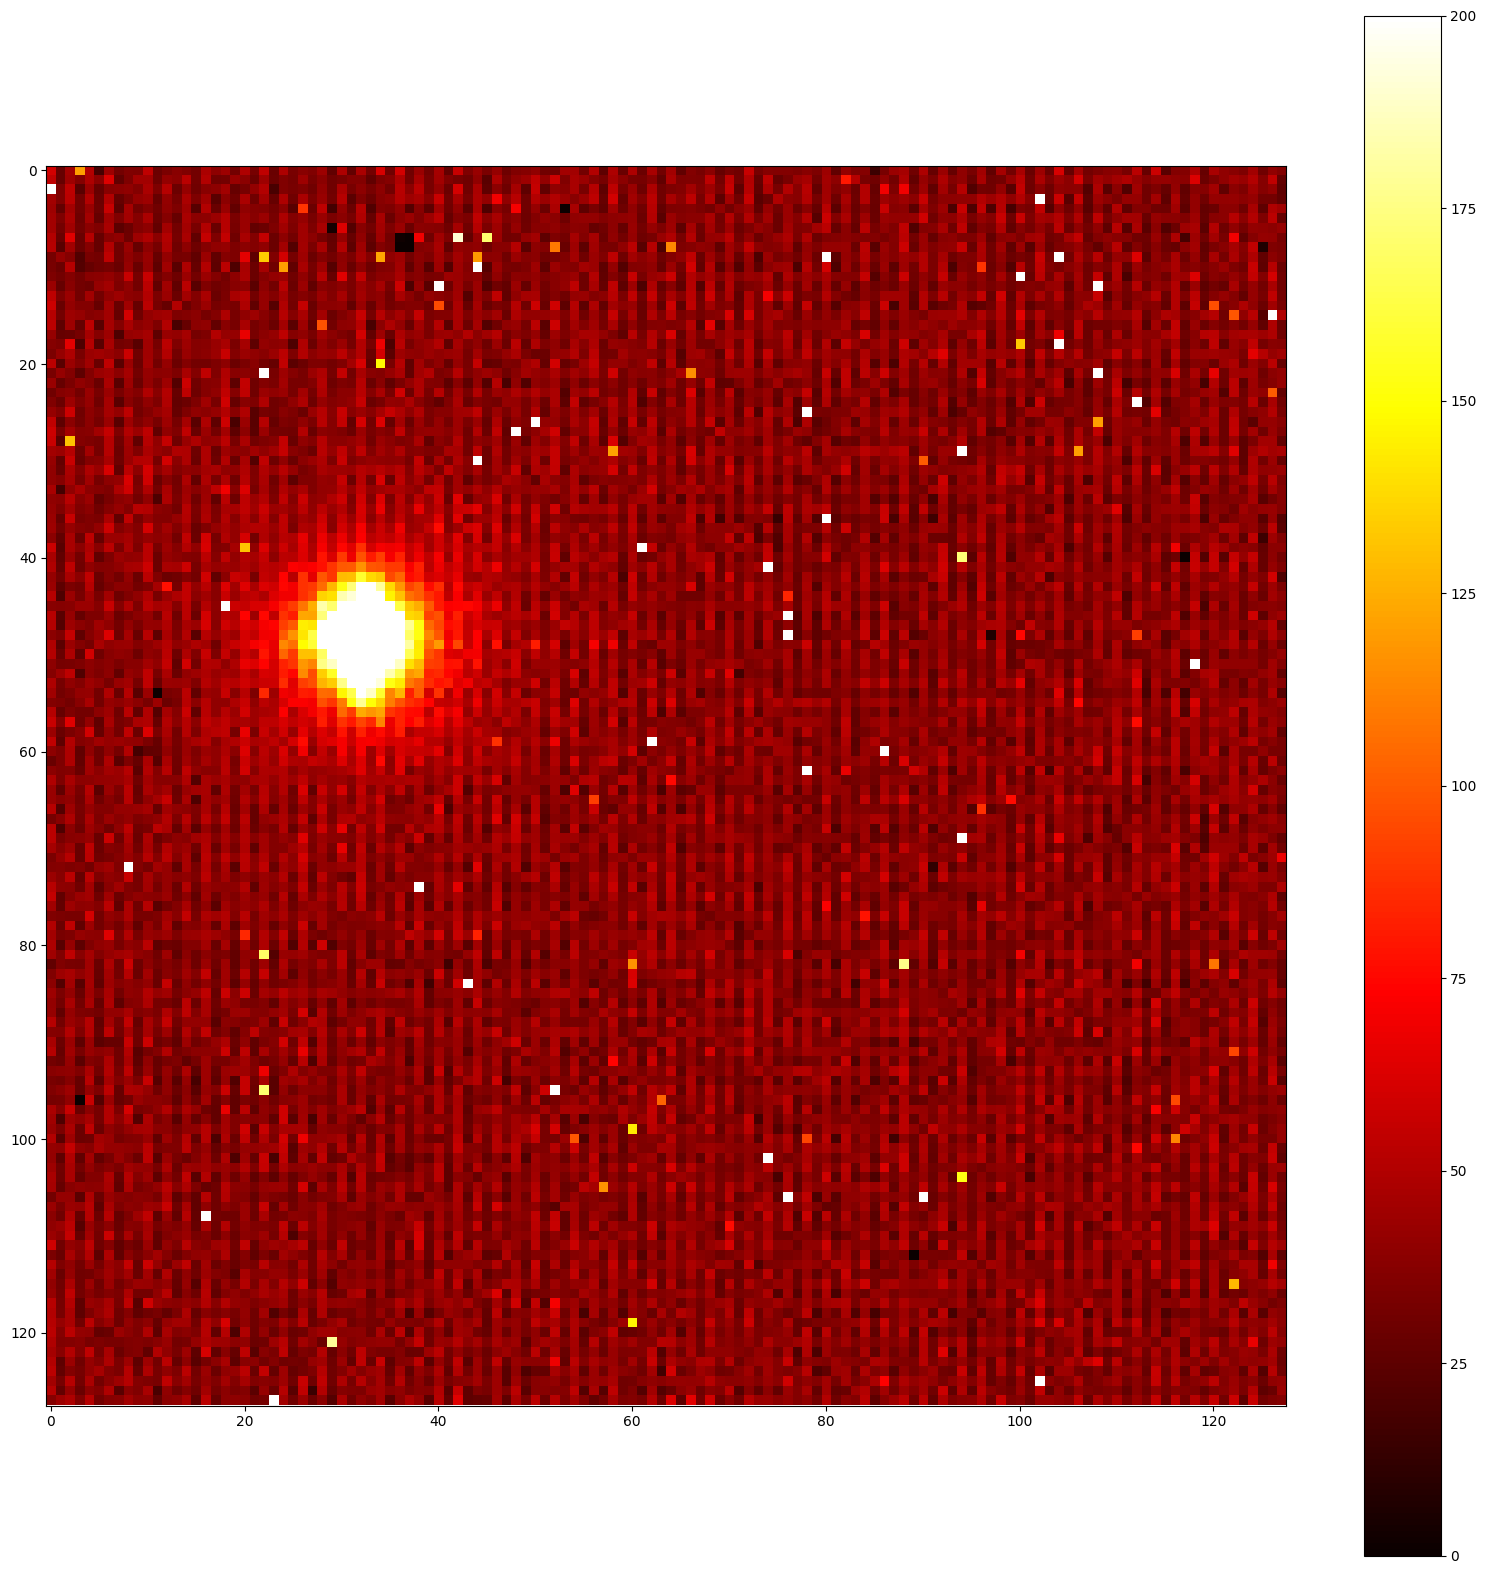

In [4]:
raw_sci = fits.open(filelist_sci[0])[0].data
crop = 128
dimx = raw_sci.shape[0]
dimy = raw_sci.shape[1]
x1 = int((dimx - crop)/2)
x2 = int(x1 + crop)
y1 = int((dimy - crop)/2)
y2 = int(y1 + crop)
raw_sci = shift(raw_sci,[-100,-100])
raw_cropped = raw_sci[x1:x2,y1:y2]
raw_cropped.shape
plt.figure(figsize=(20,20))
plt.imshow(raw_cropped,vmin=0,vmax=200,cmap='hot')
plt.colorbar()
plt.show();

The above pixel values are simply what were measured on the CCD when attempting to observe the exoplanet 2M1207, with no editing or corrections yet. 

We wrote a function to crop a given frame to crop the darks, flats, and biases as well as to make sure they are cropped the same way as the raw science frame.  

https://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html 

mad_std is the median absolute deviation (1.4826 times larger than the standard deviation for a normal distribution) and is 
\begin{align}
\text{MAD} = \text{median}(|X_i - \text{median}(X)|)
\end{align}

The below function named characterize implements the function named mad_std and also returns important statistics for a given image. 

We now statistically characterize the pixel values in the above image.
The average is 43.6221
The median is 39.0
The standard deviation is 52.145508
The median absolute deviation is 10.378215529539215
A histogram of the pixel value is shown below.


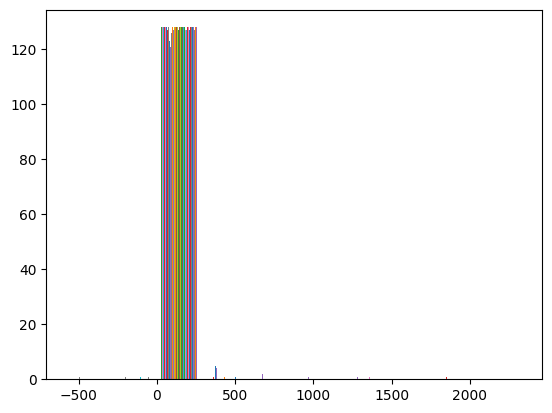

In [5]:
def characterize(frame, give_nums = False):
    avg, med = np.average(frame), np.median(frame)
    SD, MAD = np.std(frame), mad_std(frame)
    if give_nums:
        stat_dict = {}
        stat_dict["average"], stat_dict["standard deviation"] = avg, SD
        stat_dict["median absolute deviation"] = MAD
        stat_dict["median"] = med
        return stat_dict
    print("We now statistically characterize the pixel values in the "
         + "above image.\nThe average is " + str(avg) + "\n" + 
         "The median is " + str(med) + "\n" + 
          "The standard deviation is "+ str(SD) + "\n" + 
         "The median absolute deviation is " + str(MAD) + 
          "\n" + "A histogram of the pixel value is shown below.")
    plt.hist(frame)
characterize(raw_cropped)

## H BAND MASTER DARKS

The function get_frames retrieves all of the frames for a given band. The options are one of the following strings: "Hband", "Jband", "Kband", or "Lband" since those are the names of the directories for each wavelength band.

The function get_frames returns a dictionary. To access the flats simply use frames_dict['flats']

The function get_frames_dir is a helper function that reads every .fits file for each type of exposure: 'flats' , 'dark flats' which have a different exposure as reported above, 'sci' for science, and 'darks'. 

In [6]:
def get_frames(band, path_input = '/home/ubuntu/Downloads/2M1207_bands/',
             sep = '/'):
    frames_dict = {}
    path_input = path_input + band + sep
    frames_dict['flats'] = get_frames_from_dir(path_input+'flats'+sep)
    frames_dict['flat darks'] = get_frames_from_dir(path_input+'flats' 
                                                    + sep + 'darks'+sep)
    frames_dict['sci'] = get_frames_from_dir(path_input+'sci' + sep)
    frames_dict['darks'] = get_frames_from_dir(path_input+'darks' + sep)
    return frames_dict

def get_frames_from_dir(dir_path):
    frame_paths = glob.glob(dir_path + '*.fits')
    return [fits.open(frame_paths[file_num])[0].data
                for file_num in range(len(frame_paths))]

jband_dict, hband_dict = get_frames("Jband"), get_frames("Hband")
kband_dict, lband_dict = get_frames("Kband"), get_frames("Lband")
hband_dict['darks']

[array([[ 137.66667 ,  117.166664,  112.666664, ...,  136.16667 ,
          124.5     ,  218.33333 ],
        [  66.166664,   53.333332,   74.666664, ...,   37.833332,
           60.5     ,   44.333332],
        [  57.166668,   63.833332,  117.      , ...,   70.833336,
          145.5     ,   54.333332],
        ...,
        [  41.833332,    0.      ,   60.833332, ...,   27.      ,
           54.166668,   29.833334],
        [  55.166668,  -53.166668,   33.166668, ...,   23.833334,
           41.666668,   -0.5     ],
        [ -12.      , -166.5     ,  -20.166666, ...,  -60.166668,
          -18.833334,  378.66666 ]], dtype='>f4'),
 array([[ 137.33333  ,  115.833336 ,  113.5      , ...,  142.16667  ,
          121.833336 ,  217.83333  ],
        [  66.       ,   55.333332 ,   76.333336 , ...,   44.333332 ,
           58.       ,   46.       ],
        [  55.166668 ,   62.5      ,  117.       , ...,   73.       ,
          141.       ,   57.       ],
        ...,
        [  53.5      , 

https://photutils.readthedocs.io/en/stable/detection.html

https://stackoverflow.com/questions/62926893/finding-median-value-of-multiple-numpy-arrays

### H BAND MASTER FLAT DARK
     
 Here we take the difference between a dark and a dark flat to be that the dark flat has a longer exposure time. We verify this below

In [7]:
#type(test_flat[0]), type(median_hband_flat)
test_path = path_input + '/flats/darks/'
test_file = 'NACO.2004-04-29T11_38_58.492.fits'
with fits.open(test_path + test_file) as hdul:
    #hdul.info()
    print("For the Hband flat darks we have for the exposure time in seconds: " + 
          str(hdul[0].header.tostring().split(
              "EXPTIME = ")[-1].split("/")[0]) ) 
    #print(dir(hdul[0].header))

For the Hband flat darks we have for the exposure time in seconds:                1.200 


In [8]:
test_path = path_input + '/darks/'
test_file = 'NACO.2004-04-27T10_58_43.506.fits'
with fits.open(test_path + test_file) as hdul:
    print("For the Hband darks we have for the exposure time in seconds: " + 
          str(hdul[0].header.tostring().split("EXPTIME = ")[-1].split("/")[0]) ) 

For the Hband darks we have for the exposure time in seconds:               30.000 


Which is the integration time reported in the original publication: https://doi.org/10.1051/0004-6361:200400056

This function returns a new frame where each pixel value is the median of each corresponding pixel value from a given array of frames.

In [9]:
def get_median_frame(array_of_frames, crop=False):
    if crop:
        stacked_frames = np.stack([make_crop(frame) 
                               for frame in array_of_frames])
    else:
        stacked_frames = np.stack(array_of_frames)
    return np.median(stacked_frames, axis=0)
def make_crop(image, crop = 128):
    dimx, dimy = image.shape[0], image.shape[1]
    x1, y1 = int((dimx - crop)/2), int((dimy - crop)/2) 
    x2, y2 = int(x1 + crop), int(y1 + crop)
    image = shift(image, [-100,-100])
    return image[x1:x2,y1:y2]

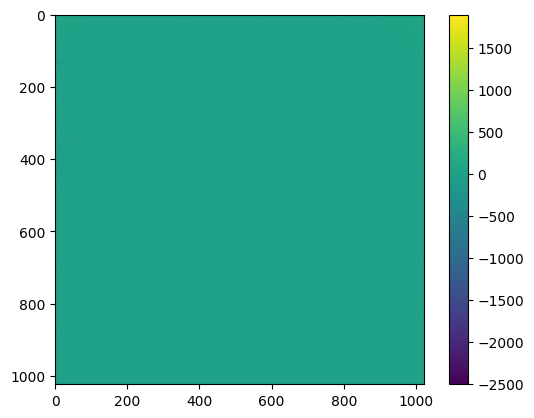

In [10]:
median_hband_short_dark = get_median_frame(hband_dict["flat darks"])
plt.imshow(median_hband_short_dark)
plt.colorbar()

We now statistically characterize the pixel values in the above image.
The average is 20.485004
The median is 18.6
The standard deviation is 30.232597
The median absolute deviation is 8.154312201780812
A histogram of the pixel value is shown below.


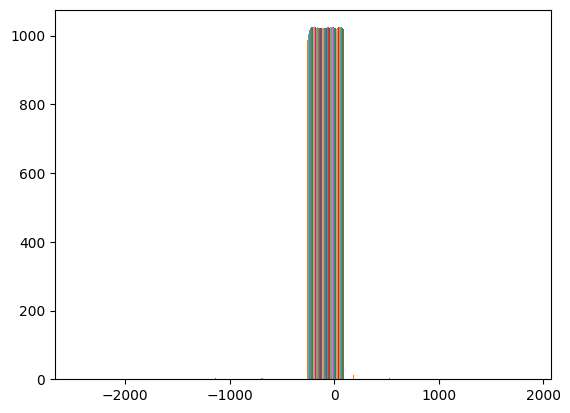

In [11]:
characterize(median_hband_short_dark)

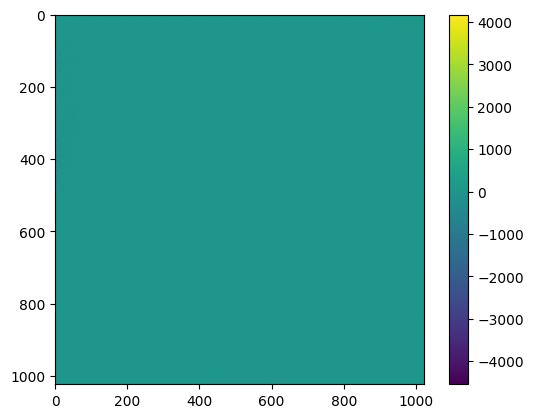

In [12]:
median_hband_dark = get_median_frame(hband_dict["darks"])
plt.imshow(median_hband_dark)
plt.colorbar()

We now statistically characterize the pixel values in the above image.
The average is 27.180977
The median is 24.333334
The standard deviation is 60.837864
The median absolute deviation is 10.131113274562072
A histogram of the pixel value is shown below.


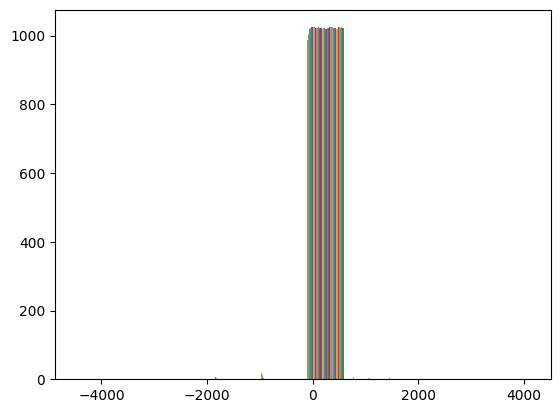

In [13]:
characterize(median_hband_dark)

## Master Hband Flat Field

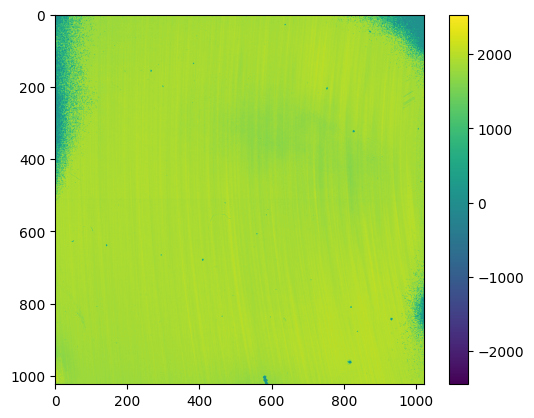

In [14]:
median_hband_flat = get_median_frame(hband_dict["flats"])
plt.imshow(median_hband_flat)
plt.colorbar()

We now statistically characterize the pixel values in the above image.
The average is 1833.601
The median is 1882.2
The standard deviation is 291.16833
The median absolute deviation is 77.68821146432064
A histogram of the pixel value is shown below.


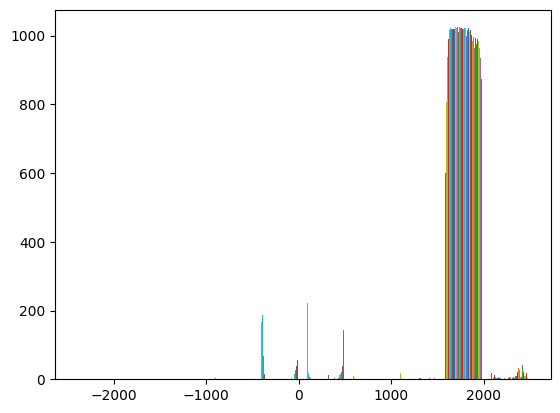

In [15]:
characterize(median_hband_flat)

# Hband Bad Pixel Map

In [16]:
hband_dark_stats = characterize(median_hband_dark, True)
hband_short_dark_stats = characterize(median_hband_short_dark, True)
hband_flat_stats = characterize(median_hband_flat, True)
hband_flat_stats, hband_short_dark_stats, hband_dark_stats

({'average': 1833.601,
  'standard deviation': 291.16833,
  'median absolute deviation': 77.68821146432064,
  'median': 1882.2},
 {'average': 20.485004,
  'standard deviation': 30.232597,
  'median absolute deviation': 8.154312201780812,
  'median': 18.6},
 {'average': 27.180977,
  'standard deviation': 60.837864,
  'median absolute deviation': 10.131113274562072,
  'median': 24.333334})

In [17]:
verbatim_hot_pixels = np.argwhere(
    median_hband_flat > hband_flat_stats["median"]
                + 2*hband_flat_stats["median absolute deviation"])
verbatim_cold_pixels = np.argwhere(
    median_hband_dark < hband_dark_stats["median"]
                - 2*hband_dark_stats["median absolute deviation"])
len(verbatim_hot_pixels), len(verbatim_cold_pixels)

(10411, 6520)

In [18]:
cold_pixels = np.argwhere(
    median_hband_flat < hband_flat_stats["median"]
                - 3*hband_flat_stats["median absolute deviation"])
hot_pixels = np.argwhere(
    median_hband_dark > hband_dark_stats["median"]
                + 3*hband_dark_stats["median absolute deviation"])
len(hot_pixels), len(cold_pixels)

(33431, 33372)

In [19]:
hband_bad_pixels = np.concatenate([hot_pixels, cold_pixels])
check1 = len(hband_bad_pixels) == len(hot_pixels) + len(cold_pixels)
check2 = sum([len(x)==2 for x in hband_bad_pixels]) == len(
    hband_bad_pixels)
if check1 and check2 and len(hband_bad_pixels)>0:
    print("It worked")
else:   
    if not check1:
        print("Length of the array is wrong")
    if not check2:
        print("Each bad pixel does not have a pair of coordinates")
    if not len(bad_pixels)>0:
        print("No bad pixels found")

It worked


## Sky From Dithered Science Frames

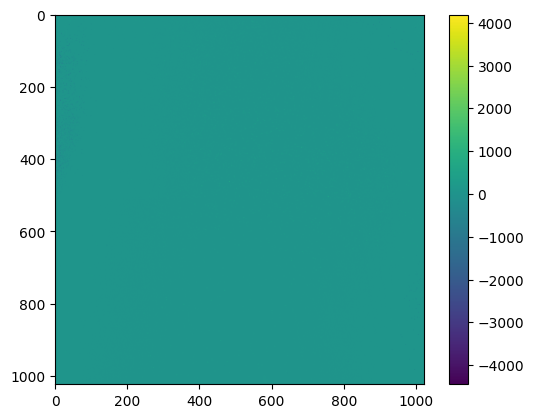

In [20]:
hband_sky = get_median_frame(hband_dict['sci'])
plt.imshow(hband_sky)
plt.colorbar()

We now statistically characterize the pixel values in the above image.
The average is 40.01339
The median is 37.75
The standard deviation is 58.46128
The median absolute deviation is 10.378215529539215
A histogram of the pixel value is shown below.


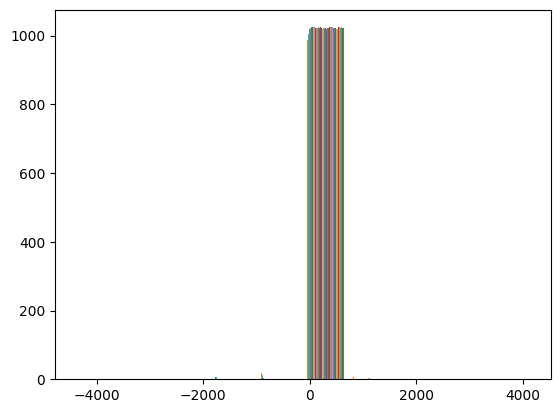

In [21]:
characterize(hband_sky)

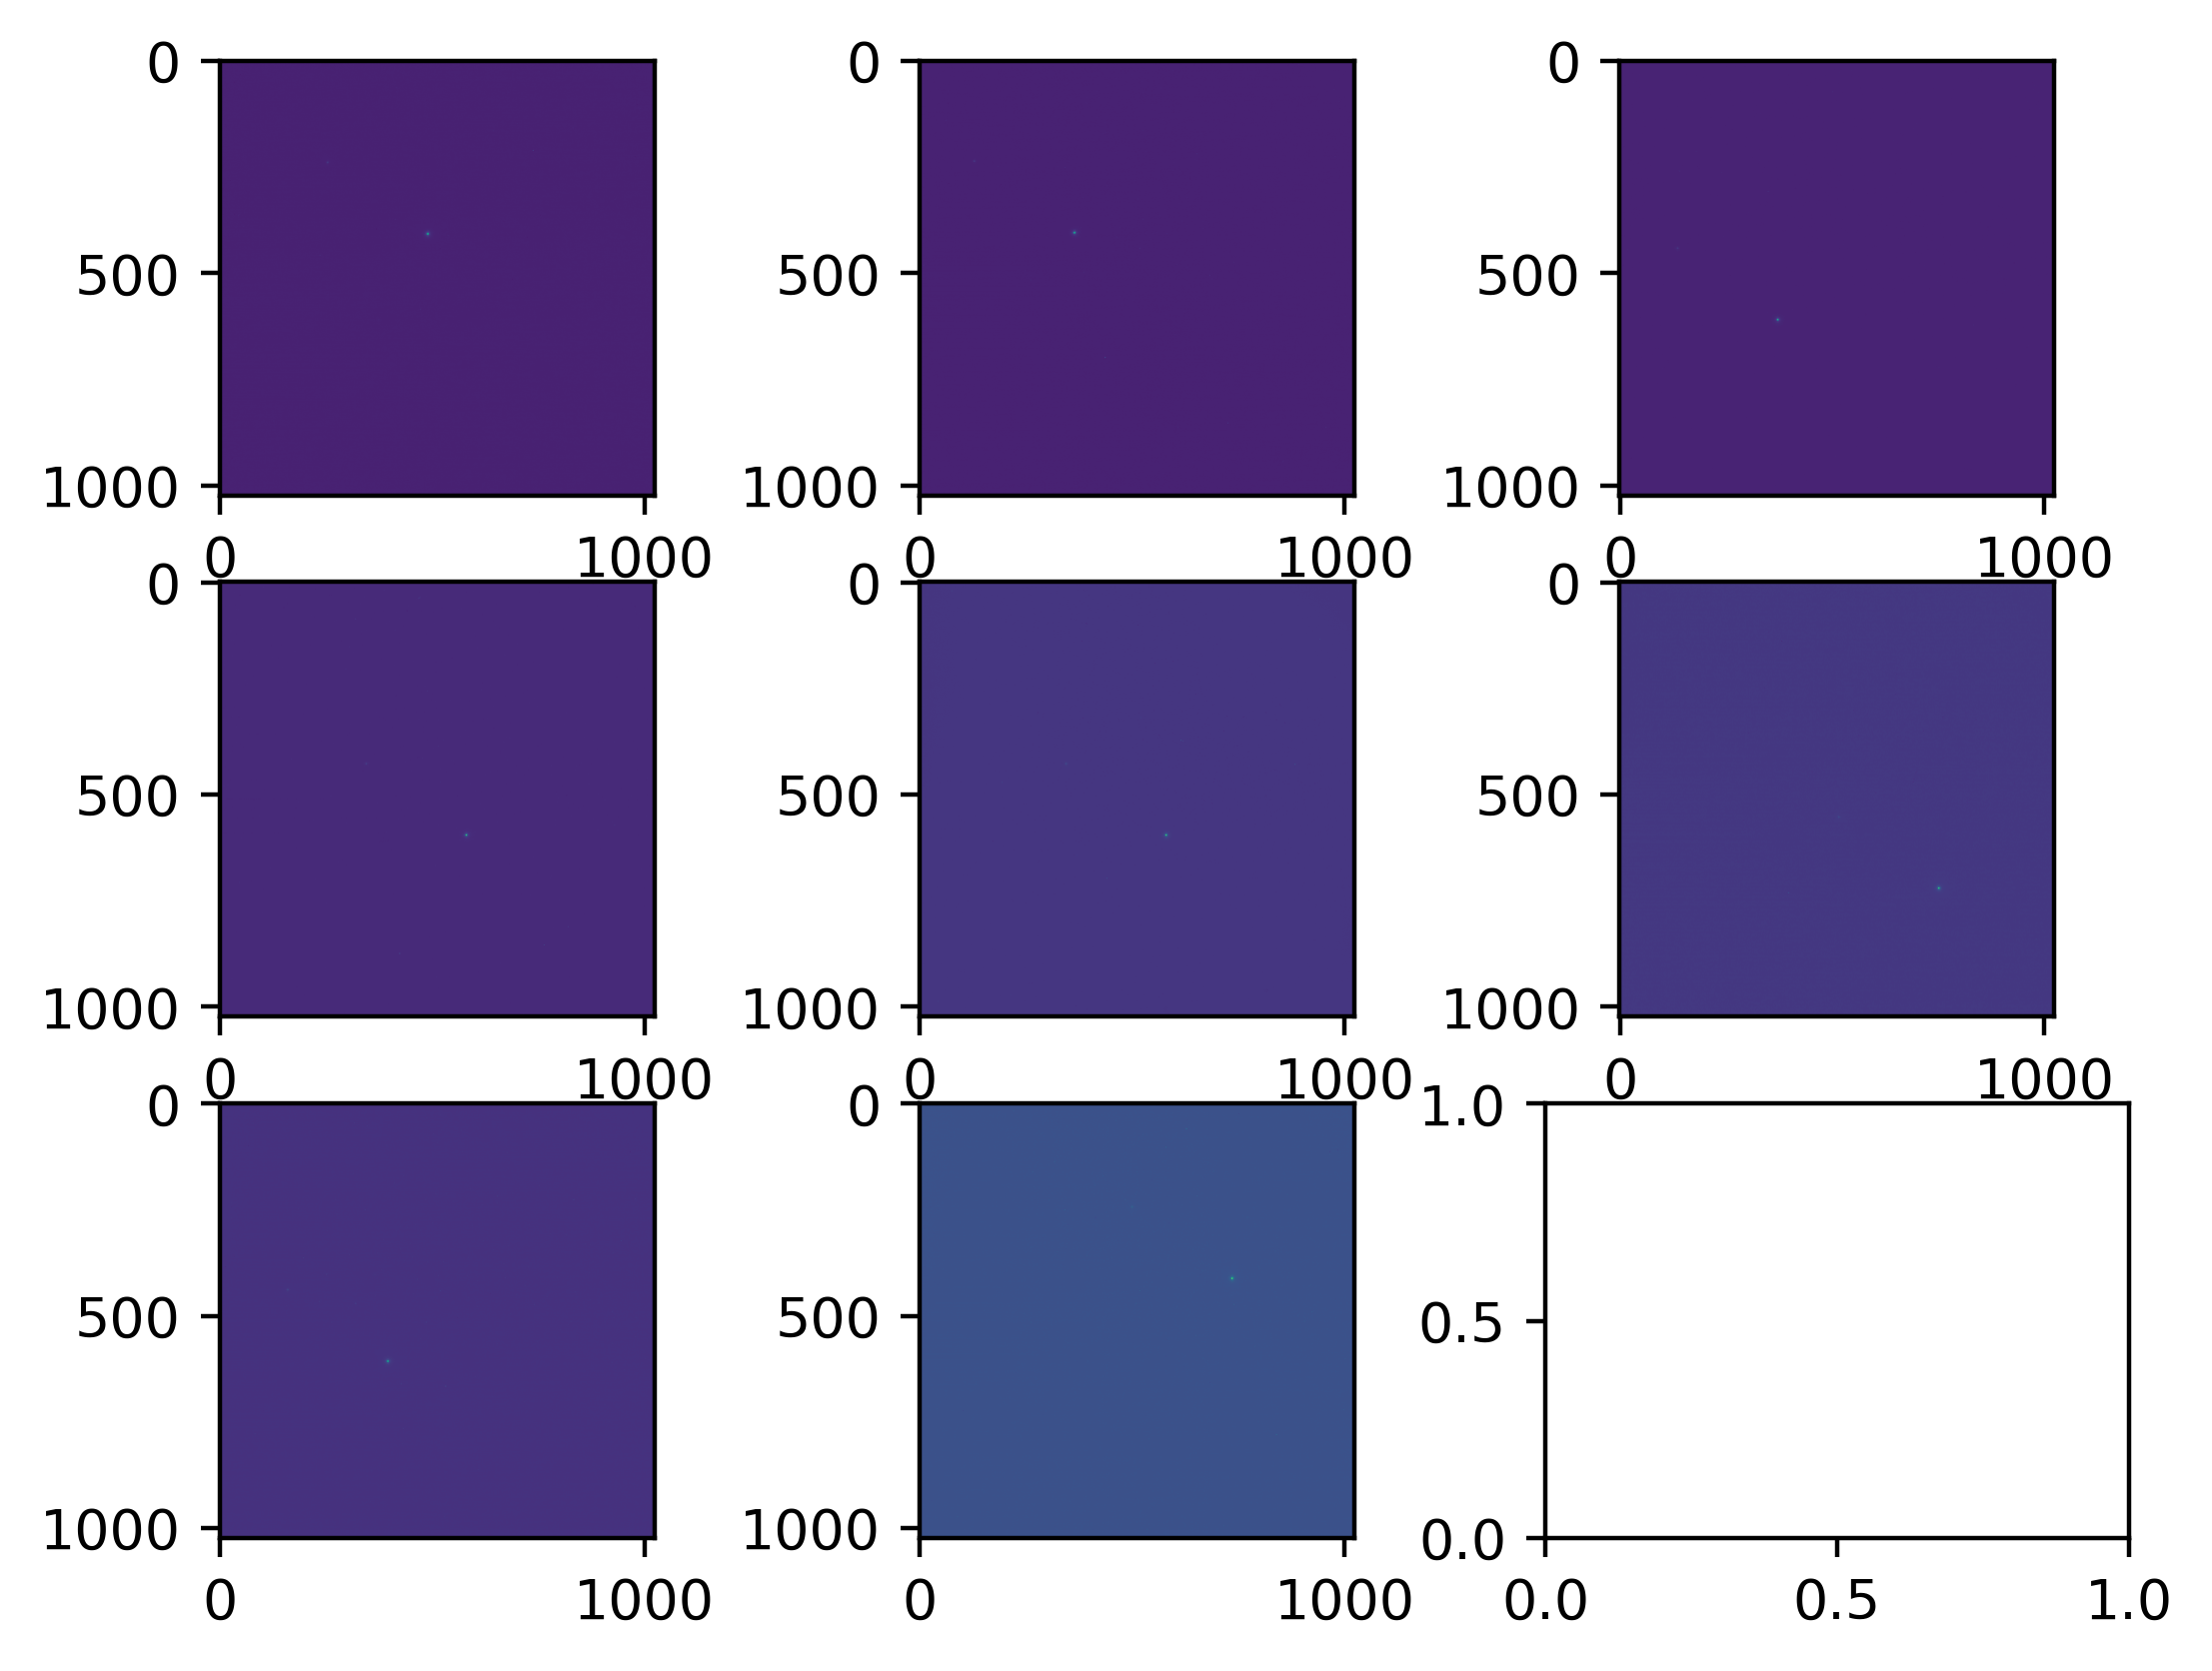

In [42]:
no_sky_hband_arr = [x- hband_sky for x in hband_dict['sci']]
fig, axs = plt.subplots(3, 3, dpi=400)
for i in range(len(no_sky_hband_arr)):
    r, c = i%3, int(np.floor(i/3))
    axs[r, c].imshow(no_sky_hband_arr[i])

The above images generate are high resolution and thus the star (in green) can be seen at a different location in each image when zooming in. 

In [ ]:
no_sky_hband = make_crop(raw_sci) - hband_sky
characterize(no_sky_hband)

In [ ]:
plt.imshow(no_sky_hband)
plt.colorbar()

In [ ]:
plt.imshow(hband_dict['sci'][0])
plt.colorbar()

In [ ]:
frame = no_sky_hband[0]
#plt.imshow(frame)
#plt.colorbar(frame)
characterize(frame)

We will only subtract the dark flat from the flats in order to arrive at the flats we will use for the data reduction for each wavelength band, as shown above.

Now we will proceed by reducing the hband wavelength frames using the following method.
\begin{align}
\text{reduced} = \frac{\text{science} - \text{dark}}{\text{flat}-\text{bias}}
\end{align}
where we perform this formula on each corresponding pixel in each frame. 

## Hband Master Bias

## Hband Master Science

A collaborator contributed the following:
Dictionary of all usable files and our object's position in said files

posdict = {}
posdict["H"] = [(582, 597), (753, 722), (375, 610), (490, 407),
                (581, 596), (365, 405), (396, 607), (738, 412)]
posdict["J"] = [(626, 619), (479, 498), (500, 747), (794, 589)]
posdict["K"] = [(621, 611), (822, 600), (484, 782), (835, 411),
                (581, 596), (407, 439), (742, 429), (780, 796)]

The bulk of the code. I construct a few dictionaries with all the
possible master files and raw files. Those are the dictionaries that I
am referencing here, hopefully its clear.

def generate_outputs():
    bands = ["H", "J", "K"]
    mag_bands = {}
    for band in bands:
        mag_bands[band] = []
        hot_pixels = sigma_mask(masterdict[band]["darks"][1])[0]
        cold_pixels = sigma_mask(masterdict[band]["flats"][1])[0]
        bad_pixels = hot_pixels + cold_pixels
        bad_mask = np.zeros((1024, 1024)) + bad_pixels/bad_pixels
        for row in bad_mask:
            np.nan_to_num(row, 0)
        for index, file in enumerate(filedict[band]["sci"]):
            sky_no_background = fits.open(file)[0].data -
masterdict[band]["sci"][1]
            full_output = sky_no_background * (1 - bad_mask)
            hdu = fits.PrimaryHDU(full_output)
            path_input = './2M1207_bands/' + band + 'band/'
            path_output = path_input + 'out/'
            sep='/'
            file_id = file.replace(f"./2M1207_bands/{band}band/sci/",
'').replace('.fits','')
            hdu.writeto(path_output + file_id + '_out.fits', overwrite=True)
            cropped_output = crop_array(full_output,
posdict[band][index][1], posdict[band][index][0])
            mag_bands[band].append(determine_mag(cropped_output))
    return mag_bands

Cropping helper function, aligns image with its corresponding position
in the position dictionary. Builds a 2nx2n data array centered on the
object

def crop_array(datap, x_center, y_center):
    """
    Returns a cropped array of dimensions 2nx2n
    """
    n = 50
    return datap[x_center - n:x_center + n,y_center-n:y_center + n]

Function that generates the magnitude and flux values for the SED. The
code in the notebook originally had a shitty finding algorithm to find
the object but I found it to be inconsistent, so I used the fact that
the cropped images were very well aligned and manually defined the
aperture to be centered on the exoplanet. The exoplanet does not seem
to move all to much so it ends up working out

def determine_mag(data):
    bkg_sigma = mad_std(median_output)
    filter_fwhm = 206265*1630.0*1.0e-9/8.2 / 0.012
    daofind = DAOStarFinder(fwhm = filter_fwhm, threshold = 2.0*bkg_sigma)
    sources = daofind(data)
    for col in sources.colnames:
        sources[col].info.format = '%.8g'

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture([[25.73661874, 32.59190509],[49.5,
49.5]], r=filter_fwhm)
    phot_table = aperture_photometry(data, apertures)
    plt.figure(figsize = [20,20])
    plt.imshow(data,vmin=0,vmax=20,cmap='hot')
    plt.colorbar()
    apertures.plot(color = 'cyan', lw = 5, alpha = 0.75)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    planet_counts = np.min(phot_table["aperture_sum"])
    star_counts = np.max(phot_table["aperture_sum"])
    FluxRatio = planet_counts / star_counts
    print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)
    return -2.5*np.log10(FluxRatio) + 12.388

Some of the lines in the function may be deprecated so there is some
stuff you can trim out.

In [ ]:
df = pd.DataFrame(hband_dict["sci"][0])
bounds = 3
test = df.iloc[582-bounds:582+bounds, 597-bounds:597+bounds].to_numpy()
plt.imshow(test)
plt.colorbar()

In [ ]:
plt.imshow(hband_dict["sci"][-1])
plt.colorbar()

In [ ]:
median_hband_sci = get_median_frame(hband_dict["sci"])
plt.imshow(median_hband_sci)
plt.colorbar()

In [ ]:
hband_dict.keys()

bkg_sigma = mad_std(final_image_cropped)
filter_fwhm = 206265*1630.0*1.0e-9/8.2 / 0.012
daofind = DAOStarFinder(fwhm = filter_fwhm, threshold = 3.0*bkg_sigma)
sources = daofind(final_image_cropped)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print(sources)

from photutils import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=filter_fwhm)
phot_table = aperture_photometry(final_image_cropped, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

plt.figure(figsize = [20,20])
plt.imshow(final_image_cropped,vmin=0,vmax=20,cmap='hot')
plt.colorbar()
apertures.plot(color = 'cyan', lw = 5, alpha = 0.75)

print(bkg_sigma)
FluxRatio = phot_table[1][3]/phot_table[2][3]
print("Planet Mag = ", -2.5*np.log10(FluxRatio) + 12.388)